In [1]:
from sklearn.ensemble import IsolationForest
import pandas as pd

In [2]:
df_master = pd.read_pickle('../master/master.pkl')

In [6]:
df_master = pd.get_dummies(df_master, columns=['role'])

In [11]:
df_master = df_master.fillna(0)

In [12]:
df_master.columns

Index(['user_id', 'dateString', 'userDate', 'isEmployed', 'isInsider',
       'hasLogin', 'firstActivity', 'hasConnect', 'dateHour', 'probLogonRole',
       'webCount', 'countPC', 'employee_name', 'psyc_O', 'psyc_C', 'psyc_E',
       'psyc_A', 'psyc_N', 'numMonthsEmployed', 'sumExtEmailSize',
       'sumExtEmailAttachments', 'numExtEmails', 'probLogonUser',
       'webQuestionableUsage', 'role_Accountant',
       'role_AdministrativeAssistant', 'role_AdministrativeStaff',
       'role_AssemblySupervisor', 'role_Attorney', 'role_ChiefEngineer',
       'role_ComputerProgrammer', 'role_ComputerScientist',
       'role_ComputerTrainer', 'role_Director', 'role_ElectricalEngineer',
       'role_Engineer', 'role_FieldServiceEngineer', 'role_FinancialAnalyst',
       'role_HardwareEngineer', 'role_HealthSafetyEngineer',
       'role_HumanResourceSpecialist', 'role_ITAdmin',
       'role_IndustrialEngineer', 'role_LabManager', 'role_ManagementTrainer',
       'role_Manager', 'role_MaterialsEngi

In [14]:
features = ['isEmployed', 'isInsider',
       'hasLogin', 'firstActivity', 'hasConnect', 'probLogonRole',
       'webCount', 'countPC', 'psyc_O', 'psyc_C', 'psyc_E',
       'psyc_A', 'psyc_N', 'numMonthsEmployed', 'sumExtEmailSize',
       'sumExtEmailAttachments', 'numExtEmails', 'probLogonUser',
       'webQuestionableUsage', 'role_Accountant',
       'role_AdministrativeAssistant', 'role_AdministrativeStaff',
       'role_AssemblySupervisor', 'role_Attorney', 'role_ChiefEngineer',
       'role_ComputerProgrammer', 'role_ComputerScientist',
       'role_ComputerTrainer', 'role_Director', 'role_ElectricalEngineer',
       'role_Engineer', 'role_FieldServiceEngineer', 'role_FinancialAnalyst',
       'role_HardwareEngineer', 'role_HealthSafetyEngineer',
       'role_HumanResourceSpecialist', 'role_ITAdmin',
       'role_IndustrialEngineer', 'role_LabManager', 'role_ManagementTrainer',
       'role_Manager', 'role_MaterialsEngineer', 'role_Mathematician',
       'role_MechanicalEngineer', 'role_Nurse', 'role_NursePractitioner',
       'role_Physicist', 'role_President', 'role_ProductionLineWorker',
       'role_PurchasingClerk', 'role_Salesman', 'role_Scientist',
       'role_SecurityGuard', 'role_SoftwareEngineer', 'role_Statistician',
       'role_SystemsEngineer', 'role_TechnicalTrainer', 'role_Technician',
       'role_TestEngineer', 'role_VicePresident']

In [41]:
features = ['isEmployed', 'isInsider',
       'hasLogin', 'firstActivity', 'hasConnect', 'probLogonRole',
       'webCount', 'countPC', 'psyc_O', 'psyc_C', 'psyc_E',
       'psyc_A', 'psyc_N', 'numMonthsEmployed', 'sumExtEmailSize',
       'sumExtEmailAttachments', 'numExtEmails', 'probLogonUser',
       'webQuestionableUsage']

In [42]:
isolation_forest = IsolationForest(n_estimators=100, contamination=0.01)

In [43]:
isolation_forest.fit(df_master[features])

c:\Users\tlhen\python\.venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.01)

In [44]:
anomaly_scores = isolation_forest.decision_function(df_master[features])

In [45]:
df_master['anomaly_score'] = anomaly_scores

In [46]:
df_master[df_master['isInsider'] == 1][['user_id','isInsider','anomaly_score']]

,user_id,isInsider,anomaly_score
54149,CSF0929,1,0.098523
54150,CSF0929,1,0.100839
54151,CSF0929,1,0.116625
54152,CSF0929,1,0.112222
54153,CSF0929,1,0.143180
54158,CSF0929,1,0.126390
54159,CSF0929,1,0.131343
54160,CSF0929,1,0.115514
54161,CSF0929,1,0.118779
54166,CSF0929,1,0.112195


<AxesSubplot: >

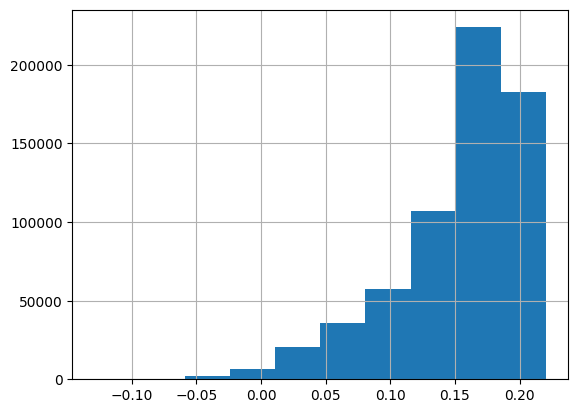

In [47]:
df_master['anomaly_score'].hist()

<AxesSubplot: >

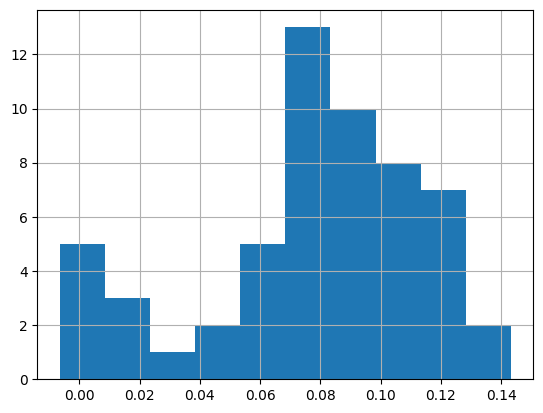

In [48]:
df_master[df_master['isInsider'] == 1]['anomaly_score'].hist()

In [49]:
pd.set_option('display.max_rows', 500)
df_master[df_master['role_ITAdmin'] != 1].nsmallest(10, 'anomaly_score').transpose()

,273494,353599,622854,570550,579837,610506,622798,622853,622797,273650
user_id,LKF0701,TGF0571,MLM0570,EBS0706,BIS0988,KHC0465,MLM0570,MLM0570,MLM0570,LKF0701
dateString,20100315,20100713,20101102,20110413,20101118,20100104,20101001,20101102,20101001,20100811
userDate,LKF0701_20100315,TGF0571_20100713,MLM0570_20101102,EBS0706_20110413,BIS0988_20101118,KHC0465_20100104,MLM0570_20101001,MLM0570_20101102,MLM0570_20101001,LKF0701_20100811
isEmployed,1,1,1,1,1,1,1,1,1,1
isInsider,0,0,0,0,0,0,0,0,0,0
hasLogin,1.0,3.0,2.0,1.0,1.0,1.0,3.0,2.0,3.0,1.0
firstActivity,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hasConnect,9.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
dateHour,6.0,7.0,13.0,7.0,7.0,7.0,18.0,7.0,11.0,7.0
probLogonRole,0.159509,0.270511,0.038683,0.270511,0.278892,0.270511,0.001015,0.270511,0.038119,0.270511
